In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=1):
    channel_size = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())        
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_8 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_9 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_72 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_17 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 32)         3104      
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5574 - acc: 0.2844
Epoch 00001: val_loss improved from inf to 2.13498, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_4_conv_checkpoint/001-2.1350.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.5576 - acc: 0.2844 - val_loss: 2.1350 - val_acc: 0.3301
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7624 - acc: 0.4623
Epoch 00002: val_loss improved from 2.13498 to 1.47457, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_4_conv_checkpoint/002-1.4746.hdf5
36805/36805 [==============================] - 76s 2ms/sample - loss: 1.7624 - acc: 0.4622 - val_loss: 1.4746 - val_acc: 0.5404
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4928 - acc: 0.5393
Epoch 00003: val_loss improved from 1.47457

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4137 - acc: 0.8666
Epoch 00026: val_loss did not improve from 1.10111
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.4137 - acc: 0.8666 - val_loss: 1.1839 - val_acc: 0.6844
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4078 - acc: 0.8676
Epoch 00027: val_loss did not improve from 1.10111
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.4078 - acc: 0.8676 - val_loss: 1.1016 - val_acc: 0.7098
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4009 - acc: 0.8698
Epoch 00028: val_loss did not improve from 1.10111
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.4009 - acc: 0.8698 - val_loss: 1.1638 - val_acc: 0.6925
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3932 - acc: 0.8714
Epoch 00029: val_loss did not improve from 1.10111
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2377 - acc: 0.9226
Epoch 00056: val_loss did not improve from 1.10111
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.2378 - acc: 0.9225 - val_loss: 1.1695 - val_acc: 0.7242
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2338 - acc: 0.9240
Epoch 00057: val_loss did not improve from 1.10111
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.2338 - acc: 0.9240 - val_loss: 1.2630 - val_acc: 0.7093
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2393 - acc: 0.9219
Epoch 00058: val_loss did not improve from 1.10111
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.2393 - acc: 0.9219 - val_loss: 1.1750 - val_acc: 0.7174
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2250 - acc: 0.9270
Epoch 00059: val_loss did not improve from 1.10111
36805/36805 [===========

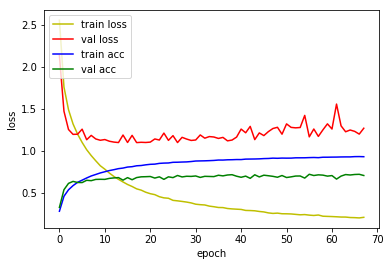

4815/4815 [==============================] - 4s 858us/sample - loss: 1.2528 - acc: 0.6415
Loss: 1.2527855815174425 Accuracy: 0.6415369

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3458 - acc: 0.3262
Epoch 00001: val_loss improved from inf to 1.86573, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_5_conv_checkpoint/001-1.8657.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 2.3457 - acc: 0.3262 - val_loss: 1.8657 - val_acc: 0.3799
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6285 - acc: 0.5033
Epoch 00002: val_loss improved from 1.86573 to 1.44014, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_5_conv_checkpoint/002-1.4401.hdf5
36805/36805 [==============================] - 79s 2ms/sample - loss: 1.6286 - acc: 0.5033 - val_loss: 1.4401 - val_acc: 0.5465
Epoch 3/500
36800/36805 [==========================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4230 - acc: 0.8624
Epoch 00027: val_loss did not improve from 0.90384
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.4231 - acc: 0.8624 - val_loss: 1.1824 - val_acc: 0.6834
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4173 - acc: 0.8661
Epoch 00028: val_loss did not improve from 0.90384
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.4173 - acc: 0.8661 - val_loss: 0.9334 - val_acc: 0.7356
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4044 - acc: 0.8699
Epoch 00029: val_loss did not improve from 0.90384
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.4043 - acc: 0.8699 - val_loss: 0.9167 - val_acc: 0.7428
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3907 - acc: 0.8740
Epoch 00030: val_loss did not improve from 0.90384
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2452 - acc: 0.9184
Epoch 00056: val_loss did not improve from 0.89846
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.2452 - acc: 0.9184 - val_loss: 0.9565 - val_acc: 0.7570
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2534 - acc: 0.9179
Epoch 00057: val_loss did not improve from 0.89846
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.2534 - acc: 0.9179 - val_loss: 1.0069 - val_acc: 0.7524
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2477 - acc: 0.9185
Epoch 00058: val_loss did not improve from 0.89846
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.2477 - acc: 0.9185 - val_loss: 1.1413 - val_acc: 0.7205
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2426 - acc: 0.9198
Epoch 00059: val_loss did not improve from 0.89846
36805/36805 [===========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1865 - acc: 0.9368
Epoch 00086: val_loss did not improve from 0.89846
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.1865 - acc: 0.9368 - val_loss: 1.0769 - val_acc: 0.7510
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1840 - acc: 0.9399
Epoch 00087: val_loss did not improve from 0.89846
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.1840 - acc: 0.9399 - val_loss: 1.0116 - val_acc: 0.7664
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1776 - acc: 0.9415
Epoch 00088: val_loss did not improve from 0.89846
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.1776 - acc: 0.9414 - val_loss: 1.0357 - val_acc: 0.7633
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1854 - acc: 0.9385
Epoch 00089: val_loss did not improve from 0.89846
36805/36805 [===========

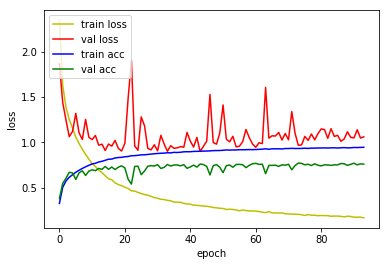

4815/4815 [==============================] - 4s 846us/sample - loss: 1.0359 - acc: 0.7200
Loss: 1.0359347320172398 Accuracy: 0.7200415

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5680 - acc: 0.2723
Epoch 00001: val_loss improved from inf to 1.83169, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_6_conv_checkpoint/001-1.8317.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 2.5680 - acc: 0.2722 - val_loss: 1.8317 - val_acc: 0.3823
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7681 - acc: 0.4553
Epoch 00002: val_loss improved from 1.83169 to 1.55601, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_6_conv_checkpoint/002-1.5560.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.7681 - acc: 0.4553 - val_loss: 1.5560 - val_acc: 0.5192
Epoch 3/500
36800/36805 [=========================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6013 - acc: 0.8137
Epoch 00026: val_loss did not improve from 0.75739
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.6013 - acc: 0.8136 - val_loss: 0.9217 - val_acc: 0.7328
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5914 - acc: 0.8163
Epoch 00027: val_loss did not improve from 0.75739
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.5915 - acc: 0.8162 - val_loss: 0.7693 - val_acc: 0.7738
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5807 - acc: 0.8189
Epoch 00028: val_loss did not improve from 0.75739
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.5807 - acc: 0.8189 - val_loss: 0.8045 - val_acc: 0.7717
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5764 - acc: 0.8224
Epoch 00029: val_loss did not improve from 0.75739
36805/36805 [===========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3095 - acc: 0.8998
Epoch 00084: val_loss did not improve from 0.71398
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.3096 - acc: 0.8997 - val_loss: 0.7914 - val_acc: 0.7943
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3102 - acc: 0.8980
Epoch 00085: val_loss did not improve from 0.71398
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.3103 - acc: 0.8980 - val_loss: 0.7534 - val_acc: 0.8022
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3098 - acc: 0.8992
Epoch 00086: val_loss did not improve from 0.71398
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.3098 - acc: 0.8991 - val_loss: 0.8123 - val_acc: 0.7955
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3062 - acc: 0.9002
Epoch 00087: val_loss did not improve from 0.71398
36805/36805 [===========

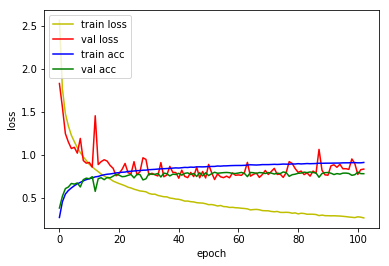

4815/4815 [==============================] - 5s 939us/sample - loss: 0.8208 - acc: 0.7657
Loss: 0.8207525815795391 Accuracy: 0.7657321

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7542 - acc: 0.2239
Epoch 00001: val_loss improved from inf to 1.77089, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_7_conv_checkpoint/001-1.7709.hdf5
36805/36805 [==============================] - 111s 3ms/sample - loss: 2.7540 - acc: 0.2239 - val_loss: 1.7709 - val_acc: 0.4519
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8983 - acc: 0.4021
Epoch 00002: val_loss improved from 1.77089 to 1.42526, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_7_conv_checkpoint/002-1.4253.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 1.8983 - acc: 0.4021 - val_loss: 1.4253 - val_acc: 0.5458
Epoch 3/500
36800/36805 [=========================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6361 - acc: 0.8058
Epoch 00025: val_loss did not improve from 0.66434
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.6362 - acc: 0.8057 - val_loss: 0.7055 - val_acc: 0.7980
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6259 - acc: 0.8086
Epoch 00026: val_loss did not improve from 0.66434
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.6258 - acc: 0.8086 - val_loss: 0.6739 - val_acc: 0.8053
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6095 - acc: 0.8137
Epoch 00027: val_loss did not improve from 0.66434
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.6097 - acc: 0.8137 - val_loss: 0.7003 - val_acc: 0.7925
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6025 - acc: 0.8172
Epoch 00028: val_loss improved from 0.66434 to 0.63486, saving model to mod

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2961 - acc: 0.9064
Epoch 00082: val_loss did not improve from 0.57393
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.2961 - acc: 0.9064 - val_loss: 0.7237 - val_acc: 0.8260
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2938 - acc: 0.9051
Epoch 00083: val_loss did not improve from 0.57393
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.2938 - acc: 0.9051 - val_loss: 0.7124 - val_acc: 0.8206
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2986 - acc: 0.9041
Epoch 00084: val_loss did not improve from 0.57393
36805/36805 [==============================] - 83s 2ms/sample - loss: 0.2986 - acc: 0.9041 - val_loss: 0.6784 - val_acc: 0.8321
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2911 - acc: 0.9079
Epoch 00085: val_loss did not improve from 0.57393
36805/36805 [===========


1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_7_conv Model


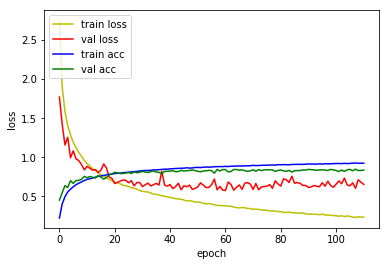

4815/4815 [==============================] - 4s 931us/sample - loss: 0.6737 - acc: 0.8104
Loss: 0.6737026598594642 Accuracy: 0.8103842

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6825 - acc: 0.2348
Epoch 00001: val_loss improved from inf to 1.90843, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_8_conv_checkpoint/001-1.9084.hdf5
36805/36805 [==============================] - 120s 3ms/sample - loss: 2.6826 - acc: 0.2348 - val_loss: 1.9084 - val_acc: 0.4265
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9271 - acc: 0.3925
Epoch 00002: val_loss improved from 1.90843 to 1.34104, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_8_conv_checkpoint/002-1.3410.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.9271 - acc: 0.3924 - val_loss: 1.3410 - val_acc: 0.5882
Epoch 3/500
36800/36805 [=========================

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2057 - acc: 0.9362
Epoch 00050: val_loss did not improve from 0.25666
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2059 - acc: 0.9362 - val_loss: 0.2950 - val_acc: 0.9157
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2014 - acc: 0.9369
Epoch 00051: val_loss did not improve from 0.25666
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2015 - acc: 0.9369 - val_loss: 0.2696 - val_acc: 0.9234
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2016 - acc: 0.9353
Epoch 00052: val_loss did not improve from 0.25666
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.2018 - acc: 0.9353 - val_loss: 0.3007 - val_acc: 0.9133
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1985 - acc: 0.9376
Epoch 00053: val_loss did not improve from 0.25666
36805/36805 [===========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1232 - acc: 0.9598
Epoch 00080: val_loss did not improve from 0.25666
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1235 - acc: 0.9597 - val_loss: 0.3024 - val_acc: 0.9227
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1204 - acc: 0.9608
Epoch 00081: val_loss did not improve from 0.25666
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1204 - acc: 0.9608 - val_loss: 0.3274 - val_acc: 0.9115
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1167 - acc: 0.9621
Epoch 00082: val_loss did not improve from 0.25666
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1169 - acc: 0.9621 - val_loss: 0.3416 - val_acc: 0.9157
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1359 - acc: 0.9552
Epoch 00083: val_loss did not improve from 0.25666
36805/36805 [===========

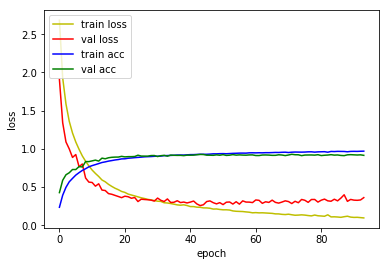

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.3358 - acc: 0.9070
Loss: 0.3357766230282135 Accuracy: 0.90695745

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4075 - acc: 0.3226
Epoch 00001: val_loss improved from inf to 2.04603, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_9_conv_checkpoint/001-2.0460.hdf5
36805/36805 [==============================] - 131s 4ms/sample - loss: 2.4079 - acc: 0.3226 - val_loss: 2.0460 - val_acc: 0.3431
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4159 - acc: 0.5649
Epoch 00002: val_loss improved from 2.04603 to 0.83573, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_9_conv_checkpoint/002-0.8357.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 1.4163 - acc: 0.5649 - val_loss: 0.8357 - val_acc: 0.7445
Epoch 3/500
36800/36805 [==========================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1732 - acc: 0.9461
Epoch 00024: val_loss did not improve from 0.19302
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1734 - acc: 0.9461 - val_loss: 0.2006 - val_acc: 0.9394
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1628 - acc: 0.9483
Epoch 00025: val_loss did not improve from 0.19302
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1629 - acc: 0.9482 - val_loss: 0.2172 - val_acc: 0.9378
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1665 - acc: 0.9491
Epoch 00026: val_loss improved from 0.19302 to 0.17690, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_9_conv_checkpoint/026-0.1769.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 0.1666 - acc: 0.9490 - val_loss: 0.1769 - val_acc: 0.9453
Epoch 27/500
36800/36805 [============================>.] - ETA

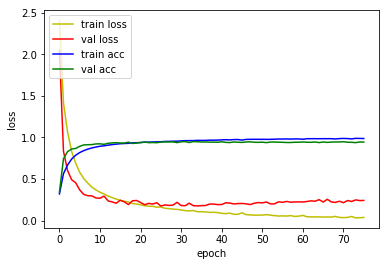

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2746 - acc: 0.9236
Loss: 0.2745589104768272 Accuracy: 0.9235722



In [10]:
base = '1D_CNN_custom_conv_3_VGG_ch_32_DO_BN'

for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [8]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_ch_32_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_4_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 32)        

4815/4815 [==============================] - 4s 788us/sample - loss: 1.0359 - acc: 0.7200
Loss: 1.0359347320172398 Accuracy: 0.7200415

1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_108 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_108 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_22 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_109 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_23 (Activat

4815/4815 [==============================] - 4s 880us/sample - loss: 0.6737 - acc: 0.8104
Loss: 0.6737026598594642 Accuracy: 0.8103842

1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_134 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_134 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_26 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_135 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_27 (Activat

4815/4815 [==============================] - 5s 945us/sample - loss: 0.2746 - acc: 0.9236
Loss: 0.2745589104768272 Accuracy: 0.9235722


In [9]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_90 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_91 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_19 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_92 (Conv1D)       

4815/4815 [==============================] - 5s 967us/sample - loss: 0.9509 - acc: 0.7537
Loss: 0.9508819115867496 Accuracy: 0.75368637

1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_120 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_24 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_121 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_25 (Activa

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.4539 - acc: 0.8916
Loss: 0.45389406679822897 Accuracy: 0.8915888

1D_CNN_custom_conv_3_VGG_ch_32_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_150 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_151 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_29 (Activati